In [1]:
import torch
from torch import nn

In [2]:
# lets try this with Classification problem
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

resnet18_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


'cuda'

# First lets take a look at the structure of teh network and analyze how will our MNIST which is (28,28,1) go through the architecture

In [3]:
resnet18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# We have two problems out here , channels in my data is gray and network takes 3 channels , so we need to modify the network layers and the second problem we need to take away the last layer and insert out MLP layer instead and make it learnable

In [4]:
resnet18_model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [5]:
# Count the number of learnable parameters
total_params = sum(p.numel() for p in resnet18_model.parameters() if p.requires_grad)

print("Total number of learnable parameters:", total_params)

Total number of learnable parameters: 11689512


In [6]:
# we will turn off models parameters
for param in resnet18_model.parameters():
  param.requires_grad = False
print(resnet18_model.fc.out_features) # -> print the out features of the resnet 18 model -> 1000 neuron
num_features = resnet18_model.fc.in_features # this is getting the 512 neurons


# we need to change also the first conv2d layer to adjust for our case "gray images"
resnet18_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)



# now lets make an trainable mlp layer
resnet18_model.fc = nn.Sequential (
    nn.Linear(num_features,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,10), # -> len(labels) labels according to labels
)

# we will take the fc layer after modification and print it out
resnet18_model.fc

1000


Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
# Count the number of learnable parameters
total_params = sum(p.numel() for p in resnet18_model.parameters() if p.requires_grad)

print("Total number of learnable parameters:", total_params)

Total number of learnable parameters: 137034


In [8]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset , DataLoader
from torchvision.datasets import MNIST

# Define the transforms
transform = transforms.ToTensor()

# Load the MNIST dataset
mnist_dataset = MNIST("./", train=True, transform=transform, download=True)

# Split the dataset into train and validation sets
train_dataset, val_dataset = train_test_split(mnist_dataset, test_size=0.2, random_state=42)

# Load the test dataset
test_dataset = MNIST("./", train=False, transform=transform, download=True)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


100%|██████████| 9912422/9912422 [00:00<00:00, 103725085.81it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102919026.19it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32726793.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19165521.90it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [9]:
x , y = next(iter(train_loader))
x[0].shape , y.shape

(torch.Size([1, 28, 28]), torch.Size([128]))

Text(0.5, 1.0, 'tensor(2)')

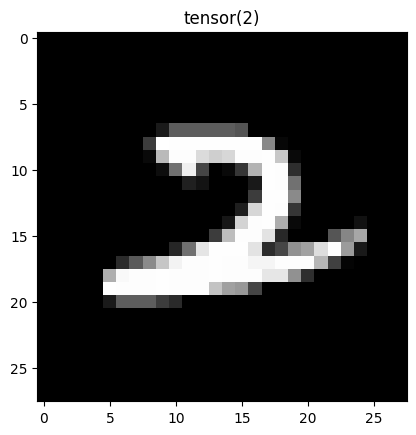

In [10]:
# lets visualize one of these
import matplotlib.pyplot as plt

index = 7
image = x[index]
image_per = image.permute(1,2,0)
image_per.shape
plt.imshow(image_per,cmap='gray')
plt.title(y[index])

In [11]:
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.parameters(),lr=0.01)

In [15]:
from tqdm.autonotebook import tqdm

def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
               optimizer : torch.optim.Optimizer,
              device : torch.device = 'cpu'):

    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)

        optimizer.zero_grad()
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    return train_loss


In [16]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device : torch.device = 'cpu'):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100. * correct
    return test_loss, accuracy

In [18]:
epochs = 1
resnet18_model.to('cuda')

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")

    # Training
    train_loss = train_step(model=resnet18_model, dataloader=train_loader, loss_fn=loss_fn, optimizer=optimizer, device='cuda')

    # Validation
    validation_loss, accuracy = test_step(dataloader=val_loader, model=resnet18_model, loss_fn=loss_fn, device='cuda')

    # Update learning rate scheduler based on validation loss
    # lr_scheduler.step(validation_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%")


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Epoch 1, Train Loss: 202.9096, Validation Loss: 0.4775, Accuracy: 85.21%


In [19]:
torch.save(resnet18_model.state_dict(),'./best.pth')

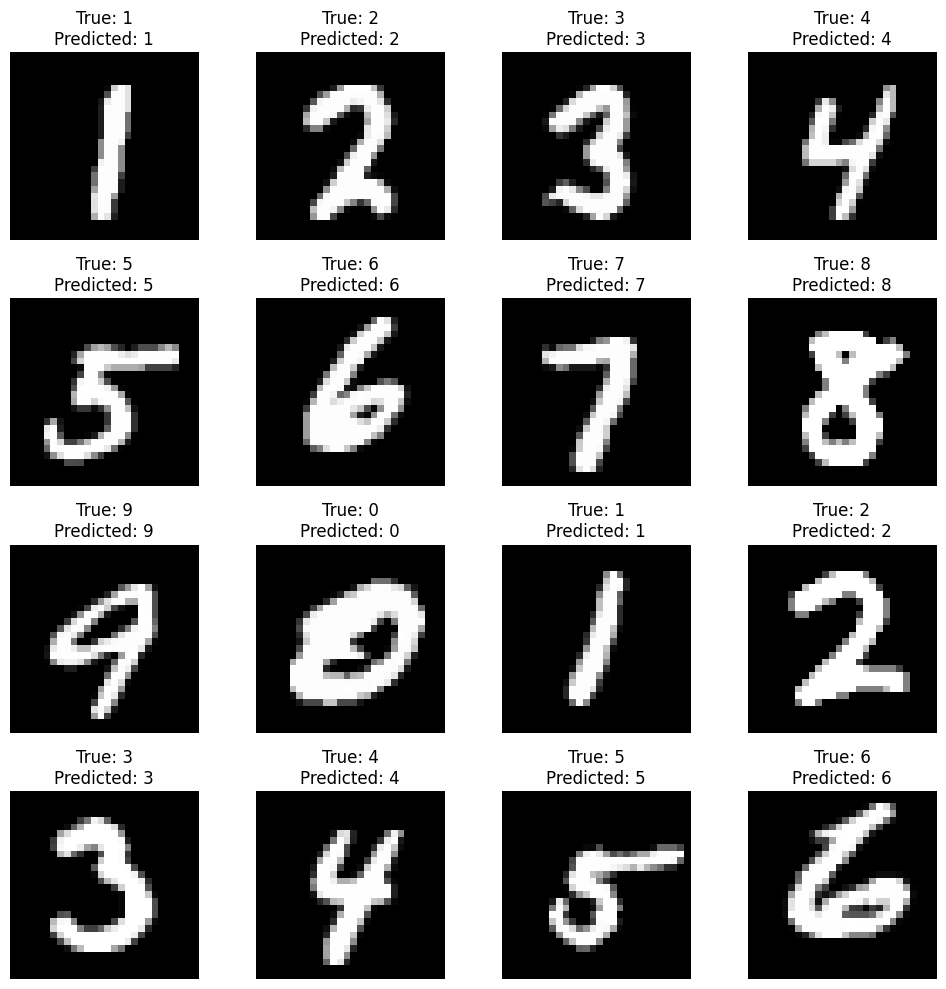

In [22]:
# Define your model architecture

resnet18_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18_model.fc = nn.Sequential (
    nn.Linear(num_features,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,10), # -> len(labels) labels according to labels
)

# Initialize your model
model = resnet18_model

# Load the saved model weights
model.load_state_dict(torch.load('./best.pth'))

# Put the model in evaluation mode
model.eval()

# Define the test dataset
# test_dataset = MNIST(root='./', train=False, transform=transforms.Compose([ToTensor()]))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define class labels for MNIST dataset
class_labels = [str(i) for i in range(10)]

# Make predictions on the test set and visualize images with true and predicted labels
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for j in range(min(len(images), 16)):
            image = images[j].squeeze().numpy()
            true_label = class_labels[labels[j].item()]
            predicted_label = class_labels[predicted[j].item()]

            ax = axs[j // 4, j % 4]
            ax.imshow(image, cmap='gray')
            ax.axis('off')
            ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}')

plt.tight_layout()
plt.show()
